# Training an Object Detector with IceVision

In [ ]:
%matplotlib inline

In [2]:
# # Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
# !wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# # Choose your installation target: cuda11 or cuda10 or cpu
# !bash icevision_install.sh cuda11 master

In [3]:
from icevision.all import *
from fastai.callback.wandb import *
from fastai.callback.tracker import SaveModelCallback

/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/ubuntu/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17
INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /home/ubuntu/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:19


In [4]:
annotations_filepath = "../data/annotations/2022-09-29_merged_for_training.json"
img_dir = "../data/images/"

# Create the parser
parser = parsers.COCOBBoxParser(annotations_filepath = annotations_filepath, 
                                img_dir = img_dir)

In [5]:
# Parse annotations to create records
train_records, valid_records = parser.parse()
parser.class_map

100%|██████████| 154/154 [00:00<00:00, 1886.15it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:122
100%|██████████| 144/144 [00:00<00:00, 19892.62it/s]


<ClassMap: {'background': 0, 'Slate': 1}>

In [6]:
# Transforms
# size is set like so because EfficientDet requires its inputs to be divisible by 128
image_size = 512
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [7]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [8]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

In [9]:
# Just change the value of selection to try another model

selection = 2

extra_args = {}

if selection == 0:
  model_type = models.mmdet.vfnet
  backbone = model_type.backbones.resnet50_fpn_mstrain_2x

if selection == 1:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x
  # extra_args['cfg_options'] = { 
  #   'model.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.bbox_head.loss_cls.loss_weight': 0.8,
  #    }

if selection == 2:
  model_type = models.mmdet.faster_rcnn
  backbone = model_type.backbones.resnet101_fpn_2x
  # extra_args['cfg_options'] = { 
  #   'model.roi_head.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.roi_head.bbox_head.loss_cls.loss_weight': 0.8,
  #    }

if selection == 3:
  model_type = models.mmdet.ssd
  backbone = model_type.backbones.ssd300

if selection == 4:
  model_type = models.mmdet.yolox
  backbone = model_type.backbones.yolox_s_8x8

if selection == 5:
  model_type = models.mmdet.yolof
  backbone = model_type.backbones.yolof_r50_c5_8x8_1x_coco

if selection == 6:
  model_type = models.mmdet.detr
  backbone = model_type.backbones.r50_8x2_150e_coco

if selection == 7:
  model_type = models.mmdet.deformable_detr
  backbone = model_type.backbones.twostage_refine_r50_16x2_50e_coco

if selection == 8:
  model_type = models.mmdet.fsaf
  backbone = model_type.backbones.x101_64x4d_fpn_1x_coco

if selection == 9:
  model_type = models.mmdet.sabl
  backbone = model_type.backbones.r101_fpn_gn_2x_ms_640_800_coco

if selection == 10:
  model_type = models.mmdet.centripetalnet
  backbone = model_type.backbones.hourglass104_mstest_16x6_210e_coco

elif selection == 11:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 12:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_d2
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 13:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.mmdet.models.faster_rcnn' from '/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/icevision/models/mmdet/models/faster_rcnn/__init__.py'>,
 {})

In [10]:
backbone.__dict__

{'model_name': 'faster_rcnn',
 'config_path': Path('/home/ubuntu/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs/faster_rcnn/faster_rcnn_r101_fpn_2x_coco.py'),
 'weights_url': 'http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r101_fpn_2x_coco/faster_rcnn_r101_fpn_2x_coco_bbox_mAP-0.398_20200504_210455-1d2dac9c.pth'}

In [11]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(
2022-09-29 06:48:13,537 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet101'}
2022-09-29 06:48:13,538 - mmcv - INFO - load model from: torchvision://resnet101
2022-09-29 06:48:13,538 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet101
2022-09-29 06:48:13,699 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-09-29 06:48:13,731 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-09-29 06:48:13,755 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2022-09-29 06:48:13,760 - mmcv - INFO - initialize 

2022-09-29 06:48:13,983 - mmcv - INFO - 
backbone.layer2.1.bn1.bias - torch.Size([128]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:13,983 - mmcv - INFO - 
backbone.layer2.1.conv2.weight - torch.Size([128, 128, 3, 3]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:13,984 - mmcv - INFO - 
backbone.layer2.1.bn2.weight - torch.Size([128]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:13,984 - mmcv - INFO - 
backbone.layer2.1.bn2.bias - torch.Size([128]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:13,985 - mmcv - INFO - 
backbone.layer2.1.conv3.weight - torch.Size([512, 128, 1, 1]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:13,986 - mmcv - INFO - 
backbone.layer2.1.bn3.weight - torch.Size([512]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:13,986 - mmcv - INFO - 
backbone.layer2.1.bn3.bias - torch.Size([512]): 
PretrainedInit: lo

2022-09-29 06:48:14,021 - mmcv - INFO - 
backbone.layer3.3.conv1.weight - torch.Size([256, 1024, 1, 1]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,021 - mmcv - INFO - 
backbone.layer3.3.bn1.weight - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,022 - mmcv - INFO - 
backbone.layer3.3.bn1.bias - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,022 - mmcv - INFO - 
backbone.layer3.3.conv2.weight - torch.Size([256, 256, 3, 3]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,023 - mmcv - INFO - 
backbone.layer3.3.bn2.weight - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,023 - mmcv - INFO - 
backbone.layer3.3.bn2.bias - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,024 - mmcv - INFO - 
backbone.layer3.3.conv3.weight - torch.Size([1024, 256, 1, 1]): 
P

2022-09-29 06:48:14,056 - mmcv - INFO - 
backbone.layer3.9.bn1.weight - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,056 - mmcv - INFO - 
backbone.layer3.9.bn1.bias - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,057 - mmcv - INFO - 
backbone.layer3.9.conv2.weight - torch.Size([256, 256, 3, 3]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,057 - mmcv - INFO - 
backbone.layer3.9.bn2.weight - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,058 - mmcv - INFO - 
backbone.layer3.9.bn2.bias - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,059 - mmcv - INFO - 
backbone.layer3.9.conv3.weight - torch.Size([1024, 256, 1, 1]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,059 - mmcv - INFO - 
backbone.layer3.9.bn3.weight - torch.Size([1024]): 
PretrainedInit

2022-09-29 06:48:14,090 - mmcv - INFO - 
backbone.layer3.15.bn1.bias - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,091 - mmcv - INFO - 
backbone.layer3.15.conv2.weight - torch.Size([256, 256, 3, 3]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,091 - mmcv - INFO - 
backbone.layer3.15.bn2.weight - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,092 - mmcv - INFO - 
backbone.layer3.15.bn2.bias - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,093 - mmcv - INFO - 
backbone.layer3.15.conv3.weight - torch.Size([1024, 256, 1, 1]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,093 - mmcv - INFO - 
backbone.layer3.15.bn3.weight - torch.Size([1024]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,094 - mmcv - INFO - 
backbone.layer3.15.bn3.bias - torch.Size([1024]): 
Pretrain

2022-09-29 06:48:14,124 - mmcv - INFO - 
backbone.layer3.21.conv2.weight - torch.Size([256, 256, 3, 3]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,124 - mmcv - INFO - 
backbone.layer3.21.bn2.weight - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,125 - mmcv - INFO - 
backbone.layer3.21.bn2.bias - torch.Size([256]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,125 - mmcv - INFO - 
backbone.layer3.21.conv3.weight - torch.Size([1024, 256, 1, 1]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,126 - mmcv - INFO - 
backbone.layer3.21.bn3.weight - torch.Size([1024]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,126 - mmcv - INFO - 
backbone.layer3.21.bn3.bias - torch.Size([1024]): 
PretrainedInit: load from torchvision://resnet101 
 
2022-09-29 06:48:14,127 - mmcv - INFO - 
backbone.layer3.22.conv1.weight - torch.Size([256, 1024, 1

2022-09-29 06:48:14,160 - mmcv - INFO - 
neck.fpn_convs.0.conv.bias - torch.Size([256]): 
The value is the same before and after calling `init_weights` of FasterRCNN  
 
2022-09-29 06:48:14,160 - mmcv - INFO - 
neck.fpn_convs.1.conv.weight - torch.Size([256, 256, 3, 3]): 
XavierInit: gain=1, distribution=uniform, bias=0 
 
2022-09-29 06:48:14,161 - mmcv - INFO - 
neck.fpn_convs.1.conv.bias - torch.Size([256]): 
The value is the same before and after calling `init_weights` of FasterRCNN  
 
2022-09-29 06:48:14,161 - mmcv - INFO - 
neck.fpn_convs.2.conv.weight - torch.Size([256, 256, 3, 3]): 
XavierInit: gain=1, distribution=uniform, bias=0 
 
2022-09-29 06:48:14,162 - mmcv - INFO - 
neck.fpn_convs.2.conv.bias - torch.Size([256]): 
The value is the same before and after calling `init_weights` of FasterRCNN  
 
2022-09-29 06:48:14,162 - mmcv - INFO - 
neck.fpn_convs.3.conv.weight - torch.Size([256, 256, 3, 3]): 
XavierInit: gain=1, distribution=uniform, bias=0 
 
2022-09-29 06:48:14,163 -

load checkpoint from local path: checkpoints/faster_rcnn/faster_rcnn_r101_fpn_2x_coco_bbox_mAP-0.398_20200504_210455-1d2dac9c.pth
The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).


In [12]:
model.to('cuda')

device=next(model.parameters()).device
device

device(type='cuda', index=0)

In [13]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

In [14]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

## Metrics

The fastai and pytorch lightning engines collect metrics to track progress during training. IceVision provides metric classes that work across the engines and libraries.

The same metrics can be used for both fastai and pytorch lightning.

In [20]:
from icevision.imports import *
from icevision.utils import *
from icevision.data import *
from icevision.metrics.metric import *


class COCOMetricType(Enum):
    """Available options for `COCOMetric`."""

    bbox = "bbox"
    mask = "segm"
    keypoint = "keypoints"


class COCOMetric(Metric):
    """Wrapper around [cocoapi evaluator](https://github.com/cocodataset/cocoapi)
    Calculates average precision.
    # Arguments
        metric_type: Dependent on the task you're solving.
        print_summary: If `True`, prints a table with statistics.
        show_pbar: If `True` shows pbar when preparing the data for evaluation.
    """

    def __init__(
        self,
        metric_type: COCOMetricType = COCOMetricType.bbox,
        iou_thresholds: Optional[Sequence[float]] = None,
        print_summary: bool = False,
        show_pbar: bool = False,
    ):
        self.metric_type = metric_type
        self.iou_thresholds = iou_thresholds
        self.print_summary = print_summary
        self.show_pbar = show_pbar
        self._records, self._preds = [], []

    def _reset(self):
        self._records.clear()
        self._preds.clear()

    def accumulate(self, preds):
        for pred in preds:
            self._records.append(pred.ground_truth)
            self._preds.append(pred.pred)

    def finalize(self) -> Dict[str, float]:
        with CaptureStdout():
            coco_eval = create_coco_eval(
                records=self._records,
                preds=self._preds,
                metric_type=self.metric_type.value,
                iou_thresholds=self.iou_thresholds,
                show_pbar=self.show_pbar,
            )
            coco_eval.evaluate()
            coco_eval.accumulate()

        with CaptureStdout(propagate_stdout=self.print_summary):
            coco_eval.summarize()

        stats = coco_eval.stats
        logs = {
            "AP (IoU=0.50:0.95) area=all": stats[0],
            "AP (IoU=0.50) area=all": stats[1],
            "AP (IoU=0.75) area=all": stats[2],
            "AP (IoU=0.50:0.95) area=small": stats[3],
            "AP (IoU=0.50:0.95) area=medium": stats[4],
            "AP (IoU=0.50:0.95) area=large": stats[5],
            "AR (IoU=0.50:0.95) area=all maxDets=1": stats[6],
            "AR (IoU=0.50:0.95) area=all maxDets=10": stats[7],
            "AR (IoU=0.50:0.95) area=all maxDets=100": stats[8],
            "AR (IoU=0.50:0.95) area=small maxDets=100": stats[9],
            "AR (IoU=0.50:0.95) area=medium maxDets=100": stats[10],
            "AR (IoU=0.50:0.95) area=large maxDets=100": stats[11],
        }

        self._reset()
        return logs

In [21]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

IceVision is an agnostic framework meaning it can be plugged into other DL learning engines such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  


### Training using fastai

In [22]:
# Instantiate wandb
wandb.init(project="Film-clapper-detector", 
           name="2022-09-28_faster_rcnn_n-50_r-512", 
           entity="boscacci-farid",
           reinit=True)

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇██
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_3,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_4,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_5,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_6,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▂▂▃▃▄▅▆▆▇▇██
lr_1,▁▁▁▂▂▃▃▄▅▆▆▇▇██
lr_2,▁▁▁▂▂▃▃▄▅▆▆▇▇██


In [23]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, 
                                  metrics=[COCOMetric(metric_type=COCOMetricType.bbox)], 
                                  cbs=[WandbCallback(), SaveModelCallback()])

In [24]:
learn.lr_find()

# For Sparse-RCNN, use lower `end_lr`
# learn.lr_find(end_lr=0.005)

/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


SuggestedLRs(valley=0.00013182566908653826)

In [25]:
learn.fine_tune(20, 0.00158, freeze_epochs=1)

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,COCOMetric,time
0,0.202439,0.302626,0.329819,00:16


Better model found at epoch 0 with valid_loss value: 0.30262622237205505.
Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,0.163716,0.137792,0.570589,00:20
1,0.144511,0.115960,0.696320,00:19
2,0.132970,0.140700,0.601213,00:19
3,0.125004,0.116614,0.674111,00:19
4,0.121065,0.191148,0.472400,00:19
5,0.123495,0.156453,0.433865,00:19
6,0.130543,0.132079,0.590206,00:19
7,0.129934,0.121055,0.615707,00:19
8,0.126709,0.096299,0.659395,00:20
9,0.115430,0.079029,0.694163,00:19


Better model found at epoch 0 with valid_loss value: 0.13779199123382568.
Better model found at epoch 1 with valid_loss value: 0.1159604862332344.
Better model found at epoch 8 with valid_loss value: 0.09629883617162704.
Better model found at epoch 9 with valid_loss value: 0.07902927696704865.
Better model found at epoch 15 with valid_loss value: 0.07174935191869736.
Better model found at epoch 17 with valid_loss value: 0.07080867141485214.
Better model found at epoch 18 with valid_loss value: 0.07058526575565338.


## Using the model - inference and showing results

The first step in reviewing the model is to show results from the validation dataset. This is easy to do with the `show_results` function.

In [32]:
%matplotlib inline

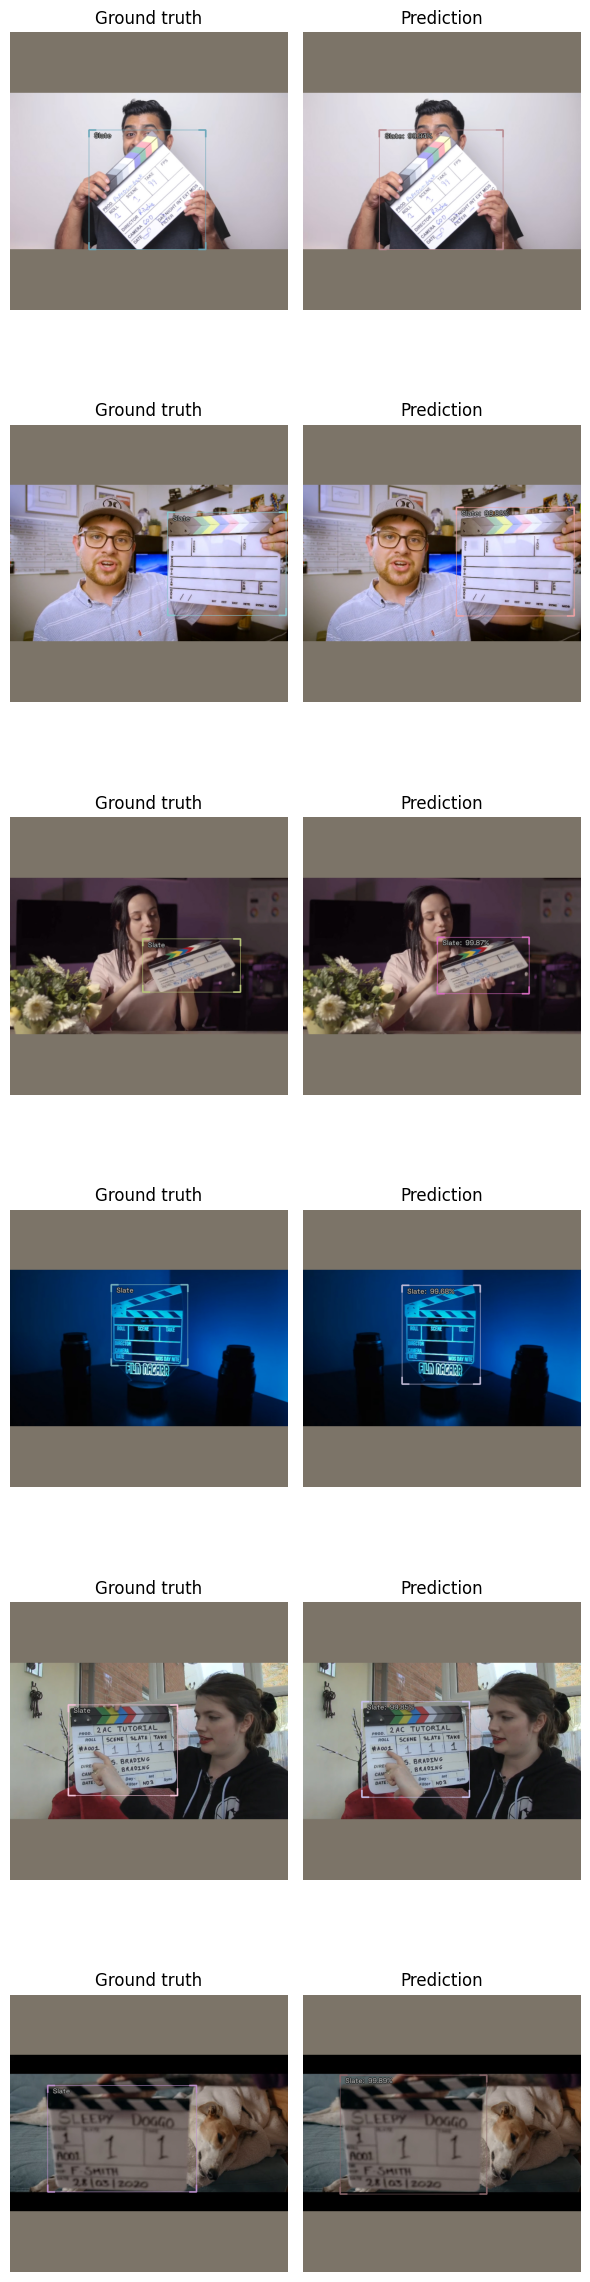

In [33]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

In [29]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


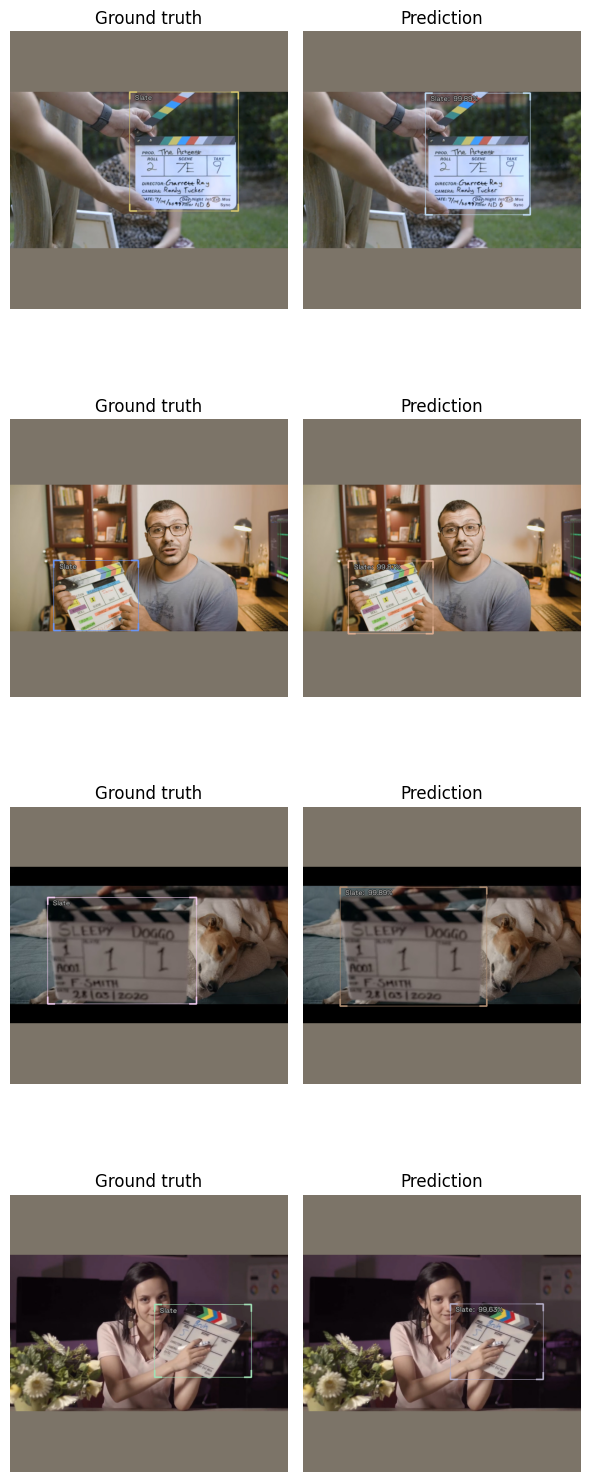

In [31]:
show_preds(preds=preds[:4])

In [34]:
# Create wandb_images for each prediction
wandb_images = wandb_img_preds(preds, add_ground_truth=True) 

# Log the wandb_images to wandb
wandb.log({"Predicted images": wandb_images})

wandb.join()

COCOMetric,▁▅▇▅▇▃▃▅▆▆▇▆▇▆▇▇█▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_3,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_4,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_5,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_6,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▃█▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▃█▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁


# Export Model

In [35]:
from icevision.models.checkpoint import *

In [36]:
model_type

<module 'icevision.models.mmdet.models.faster_rcnn' from '/home/ubuntu/.conda/envs/icevision/lib/python3.9/site-packages/icevision/models/mmdet/models/faster_rcnn/__init__.py'>

In [37]:
model_name = "mmdet.faster_rcnn"
model_name

'mmdet.faster_rcnn'

In [38]:
backbone.__dict__

{'model_name': 'faster_rcnn',
 'config_path': Path('/home/ubuntu/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs/faster_rcnn/faster_rcnn_r101_fpn_2x_coco.py'),
 'weights_url': 'http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r101_fpn_2x_coco/faster_rcnn_r101_fpn_2x_coco_bbox_mAP-0.398_20200504_210455-1d2dac9c.pth',
 'pretrained': True}

In [39]:
backbone_name = "resnet101_fpn_2x"
backbone_name

'resnet101_fpn_2x'

In [40]:
image_size

512

In [41]:
save_icevision_checkpoint(model,
                        model_name=model_name, 
                        backbone_name=backbone_name,
                        img_size=image_size,
                        classes=parser.class_map.get_classes(),
                        filename='../models/2022-09-29_resnet_slates_50.pth',
                        meta={'icevision_version': '0.12.0'})